## Понижение размерности данных. PCA, T-SNE.

In [1]:
# импорт библиотек

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import datasets
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Работа PCA на простом примере

Сгенерируем двумерные данные из нормального распределения. Для каждой размерности зададим математические ожидания. Так как выборка многомерна, то в данном случае вместо обычной дисперсии используется ковариационная матрица. Она задает описание формы случайного вектора.

Матрица ковариации имеет размер N x N, где N - число признаков (размерностей) исходных данных. На главной диагонали матрицы располагаются дисперсии признаков. Элемент матрицы ковариации с индексами [i, j], где $i \neq j$, преставляет собой ковариацию i-го и j-го признаков исходных данных.

In [2]:
m = [5, 6]
C = np.array([[3,2],[2,2]])
print('Матрица ковариации')
print(C)

Матрица ковариации
[[3 2]
 [2 2]]


Распишем, что означает каждый элемент матрицы ковариации.

In [3]:
print("Дисперсия признака X1: ", C[0,0])
print("Дисперсия признака X2: ", C[1,1])
print("Ковариация признаков X1 и X2: ", C[0,1])

Дисперсия признака X1:  3
Дисперсия признака X2:  2
Ковариация признаков X1 и X2:  2


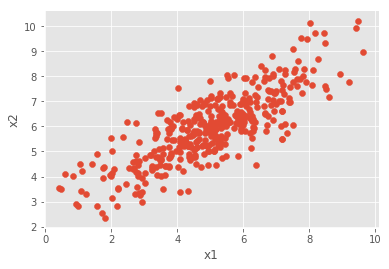

In [4]:
data = np.random.multivariate_normal(m, C, size=400)
plt.scatter(data[:,0], data[:,1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Рассмотрим, как меняется картина данных при изменении ковариации признаков.

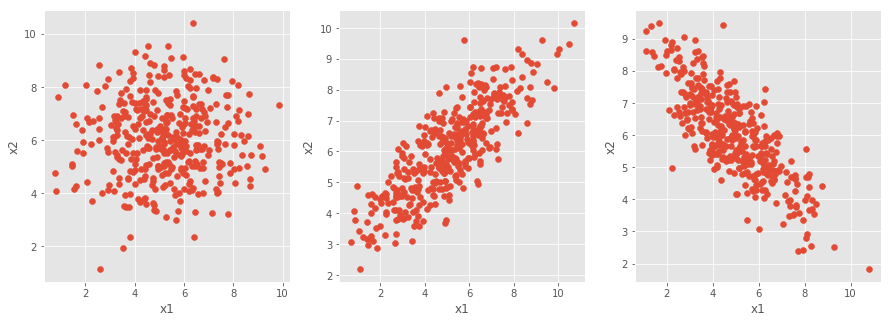

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
m = [5, 6]
C1 = np.array([[3,0],[0,2]])
data = np.random.multivariate_normal(m, C1, size=400)
ax1.scatter(data[:,0], data[:,1])
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
C2 = np.array([[3,2],[2,2]])
data = np.random.multivariate_normal(m, C2, size=400)
ax2.scatter(data[:,0], data[:,1])
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
C3 = np.array([[3,-2],[-2,2]])
data = np.random.multivariate_normal(m, C3, size=400)
ax3.scatter(data[:,0], data[:,1])
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
plt.show()

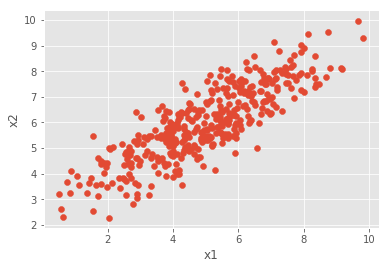

In [6]:
# сгенерируем модельные данные

mu = [5, 6]
C = np.array([[3,2],[2,2]])

data = np.random.multivariate_normal(mu, C, size=400)
plt.scatter(data[:,0], data[:,1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Отцентрируем нашу выборку – линейно сдвинем ее так, чтобы средние значения признаков были равны 0.

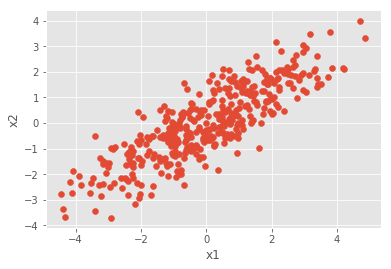

In [7]:
data_centered = data - np.mean(data, axis = 0)
plt.scatter(data_centered[:,0], data_centered[:,1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

C помощью функции np.cov построим матрицу, которая является оценкой исходной матрицы ковариации. Сравним ее с исходной матрицей ковариции.

In [8]:
covmat = np.cov(data_centered.T)
print('True covmat')
print(C)
print('Estimated covmat')
print(covmat)

True covmat
[[3 2]
 [2 2]]
Estimated covmat
[[3.21489724 2.13732824]
 [2.13732824 2.00476295]]


Вычислим собственные векторы полученной матрицы ковариации с помощью функции np.linalg.eig.

In [9]:
_, vecs = np.linalg.eig(covmat)

Построим компоненты по направлению собственных векторов.

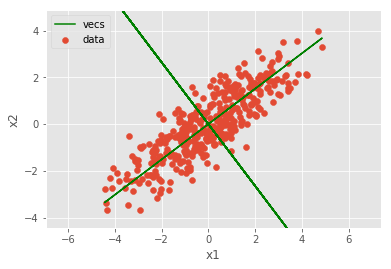

In [12]:
plt.scatter(data_centered[:,0], data_centered[:,1], label = 'data')
# построим истинные компоненты, вдоль которых максимальна дисперсия данных
plt.plot(data_centered[:,0], (vecs[1,0]/vecs[0,0])*data_centered[:,0], color="g", label = 'vecs')
plt.plot(data_centered[:,0], (vecs[1,1]/vecs[0,1])*data_centered[:,0], color="g")
plt.axis('equal')
limits = [np.minimum(np.amin(data_centered[:,0]), np.amin(data_centered[:,1])),
          np.maximum(np.amax(data_centered[:,0]), np.amax(data_centered[:,1]))]
plt.xlim(limits[0],limits[1])
plt.ylim(limits[0],limits[1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.draw()

## Использование PCA из библиотеки Scikit-learn. Отбор главных компонент

В качестве примера возьмем датасет Wine dataset. Будем решать задачу многоклассовой классификации. Датасет состоит из 13 признаков, не считая целевую переменную - сорт вина (в датасете 3 уникальных сорта). С помощью метода главных компонент мы планируем снизить размерность нашего датасета.

In [28]:
from sklearn.datasets import load_wine
data = load_wine()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = data.target
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Для начала обучим классификатор на исходных признаках. Разделим выборку на трейн и тест, обучим дерево решений на трейне, оценим качество на тесте.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)
model = DecisionTreeClassifier(max_depth=3, random_state=20)
model.fit(X_train, y_train)
preds_test = model.predict(X_test)
print(accuracy_score(y_test, preds_test))

0.8148148148148148


Далее применим метод главных компонент для снижения размерности датасета и обучим классификатор на новых признаках. Посмотрим, насколько PCA улучшит результаты для модели, которая в данном случае посредственно справляется с классификацией из-за того, что у неё не хватает сложности для описания данных.

Перед применением метода главных компонент необходимо масштабирование датасета.

In [30]:
%%html
<img src="scaling.png",width=60,height=60>

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Применим метод главных компонент.

In [32]:
pca = PCA()
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Далее нам необходимо подобрать оптимальное число главных компонент. Мы знаем, что каждой главной компоненте соответствует описываемая ей дисперсия данных. Исходя из этого, мы можем отсортировать дисперсию данных вдоль этих компонент по убыванию, и уменьшить размерность данных, отбросив $q$ итоговых главных компонент, имеющих наименьшую дисперсию. Широко применяется следующий подход: дисперсии компонент нормируются на сумму данных дисперсий. Далее по возрастанию дисперсии отбрасываются компоненты и рассчитывается сумма отнормированных дисперсий оставшихся компонент - она показывает, какой процент дисперсии исходных данных у нас остается. На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных. 
Получить отнормированные дисперсии компонент можно с помощью атрибута `explained_variance_ratio_`.

In [33]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

Отнормированные дисперсии компонент отсортированы по убыванию. Далее с конца мы будем удалять компоненты и рассчитывать сумму отнормированных дисперсий оставшихся компонент. Построим график зависимости данной величины от числа оставшихся компонент.

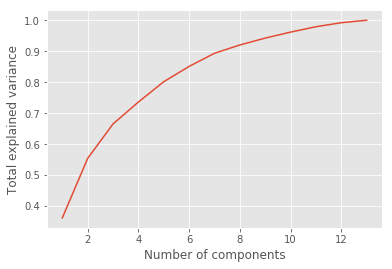

In [34]:
total_explained_variance = []
n_components = np.arange(1, len(explained_variance_ratio) + 1)
for i in n_components:
    total_explained_variance.append(explained_variance_ratio[:i].sum())
plt.plot(n_components, total_explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.show();

Видим, что можем снизить размерность датасета до 7.

In [35]:
pca = PCA(n_components = 7)
X_pca = pca.fit_transform(X_scaled)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=20, stratify = y)
model = DecisionTreeClassifier(max_depth=3, random_state=20)
model.fit(X_train, y_train)
preds_test = model.predict(X_test)
print(accuracy_score(y_test, preds_test))

0.9814814814814815


Качестве на тесте возросло. В случаях, где данные не разбиваются тривиально вдоль одного признака, применение PCA может достаточно сильно улучшить качество работы деревьев решений и ансамблей на их основе.

## Использование T-SNE из библиотеки Scikit-learn. Визуализация многомерного признакового пространства.  

В качестве примера возьмем датасет Titanic. С помощью T-SNE мы планируем снизить размерность нашего датасета до двух новых признаков и визуализировать его.

In [37]:
data = pd.read_csv('titanic_train.csv')
data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data = data.fillna(data.median())
data.head()

,pclass,sex,age,sibsp,parch,fare,survived
0,3,1,28.0,0,0,7.7333,1
1,3,0,38.0,0,0,8.6625,0
2,3,1,30.0,1,1,24.1500,0
3,2,1,54.0,1,3,23.0000,1
4,2,0,40.0,0,0,13.0000,0


In [38]:
X = data.drop('survived', axis = 1)
y = data['survived']

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Снизим размерность датасета с помощью T-SNE.

In [40]:
tsne = TSNE(n_components=2, random_state=20)
X_tsne = tsne.fit_transform(X_scaled)

Визуализируем полученный датасет. Точки, соответствующие выжившим пассажирам, окрасим в желтый цвет. Точки, соответствующие погибшим пассажирам, окрасим в зеленый цвет.

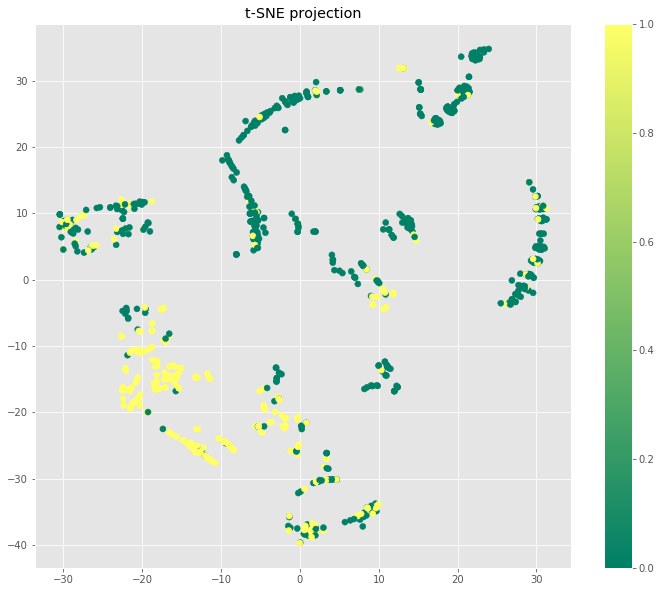

In [41]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap = 'summer')
plt.colorbar()
plt.title('t-SNE projection')
plt.show()

Видим, что на графике имеются островки, где кучкуются преимущественно объекты одного класса.

## Сравнение с визуализацией с помощью PCA 

Теперь посмотрим, как результаты работы PCA помогут в визуализации данных.

In [42]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

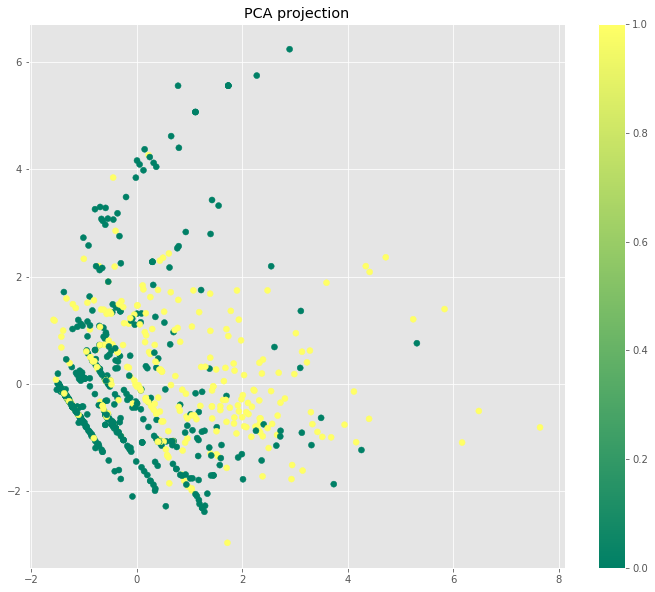

In [43]:
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap = 'summer')
plt.colorbar()
plt.title('PCA projection')
plt.show()

Видим, что с PCA картинка заметно хуже, поскольку у PCA ограничение – он находит только линейные комбинации исходных признаков.